In [4]:
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
import uuid
import requests

from pandas.tseries.offsets import BDay

KAFKA_BOOTSTRAP_SERVERS = [
    'njxmd01.hetco.com:9092'
]


def get_kafka_consumer():
    return KafkaConsumer(bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS, group_id="tst"+str(uuid.uuid4()))



DEV = True
kafka_topic = 'dev-live-fairvalue-prices'
today = datetime.today().strftime('%Y%m%d')
prev_day = (datetime.today() - BDay(1)).strftime('%Y%m%d')
print(today, prev_day)


20220404 20220401


In [5]:
kafka_consumer = get_kafka_consumer()
kafka_consumer.subscribe(topics=[kafka_topic])
start_time = datetime.now().timestamp()
print(f'start_time {start_time}')

received_msgs = {}
num_msgs = 0
for msg in kafka_consumer:
    msg_stamp = msg.timestamp/1000
    key = msg.key.decode('utf-8')
    # if not key.startswith("RB"):
    #     continue
    received_prices = msg.value.decode('utf-8')
    msg_dict = json.loads(received_prices)
    
    received_msgs[key] = {"instr":key, "bid":msg_dict['BidPr'], "ask":msg_dict['AskPr'], "book_type":msg_dict['BookType']}
    # print(f'received {received_msgs[key]}')
    num_msgs+=1
    if num_msgs % 5000 == 0:
        print(f'read {num_msgs}')
    if num_msgs == 300_000:
        break
    # print(f'received eval msg {key} {received_eval_curve}')

# df = pd.DataFrame(received_msgs.values())
# df.to_csv(f'c:\\temp\\prices{datetime.utcnow()}.csv', index=False)

kafka_consumer.unsubscribe()
kafka_consumer.close()

start_time 1649074776.643735
read 5000
read 10000
read 15000
read 20000
read 25000
read 30000
read 35000
read 40000
read 45000
read 50000
read 55000
read 60000
read 65000
read 70000
read 75000
read 80000
read 85000
read 90000
read 95000
read 100000
read 105000
read 110000
read 115000
read 120000
read 125000
read 130000
read 135000
read 140000
read 145000
read 150000
read 155000
read 160000
read 165000
read 170000
read 175000
read 180000
read 185000
read 190000
read 195000
read 200000
read 205000
read 210000
read 215000
read 220000
read 225000
read 230000
read 235000
read 240000
read 245000
read 250000
read 255000
read 260000
read 265000
read 270000
read 275000
read 280000
read 285000
read 290000
read 295000
read 300000


In [6]:

df_fv = pd.DataFrame(received_msgs.values())
df_fv.to_csv(f'c:\\temp\\dev_fv_prices_{today}.csv', index=False)

In [7]:

def get_settles_df(symbol:str, exchange:str, date:str) -> pd.DataFrame:
    url = f"http://settles-api.mosaic.hartreepartners.com/settles/api/v1/getFutureCurveSettlement/{symbol}/{exchange}/{date}?allow_indicative=true"
    data = requests.get(url)
    df = pd.DataFrame(data=data.json())
    return df[['instrument_key','expiration_date','value']].reset_index(drop=True)


In [23]:
df_cme = get_settles_df("CL,NG,HO,RB","CME",prev_day)
df_ice = get_settles_df("B,G","ICE",prev_day)



Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm Professional Edition with Anaconda plugin 2019.3.3\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_utils.py", line 69, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


In [9]:
df_settles = pd.concat([df_cme,df_ice], axis=0)

df_settles = df_settles.rename(columns={'instrument_key':'instr'})
df_fv = df_fv.where(pd.notnull(df_fv),None)
df_fv.dropna(inplace=True)
df_fv['mid'] = (df_fv['bid'].astype(float) + df_fv['ask'].astype(float))/2

In [10]:
df_c = pd.merge(df_settles, df_fv, on=['instr'], how='left')

In [11]:
df_c[['symbol','contract']] = df_c['instr'].str.split(expand=True)

In [12]:
df_cl = df_c[df_c['symbol']=='CL'].copy()

<AxesSubplot:xlabel='contract'>

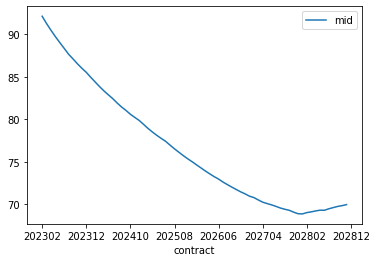

In [14]:
df_cl[['contract','value','mid']].plot(x='contract')

<AxesSubplot:xlabel='contract'>

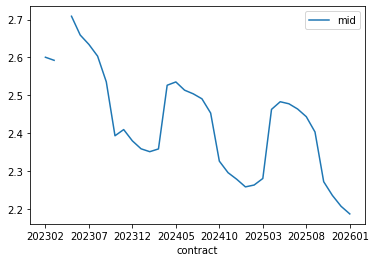

In [17]:
df_rb = df_c[df_c['symbol']=='RB'].copy()
df_rb[['contract','value','mid']].plot(x='contract')


<AxesSubplot:xlabel='contract'>

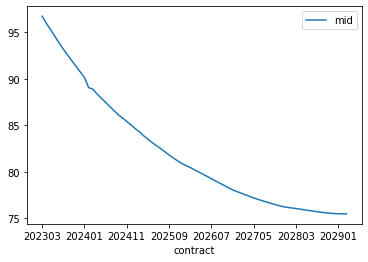

In [15]:
df_b = df_c[df_c['symbol']=='B'].copy()
df_b[['contract','value','mid']].plot(x='contract')

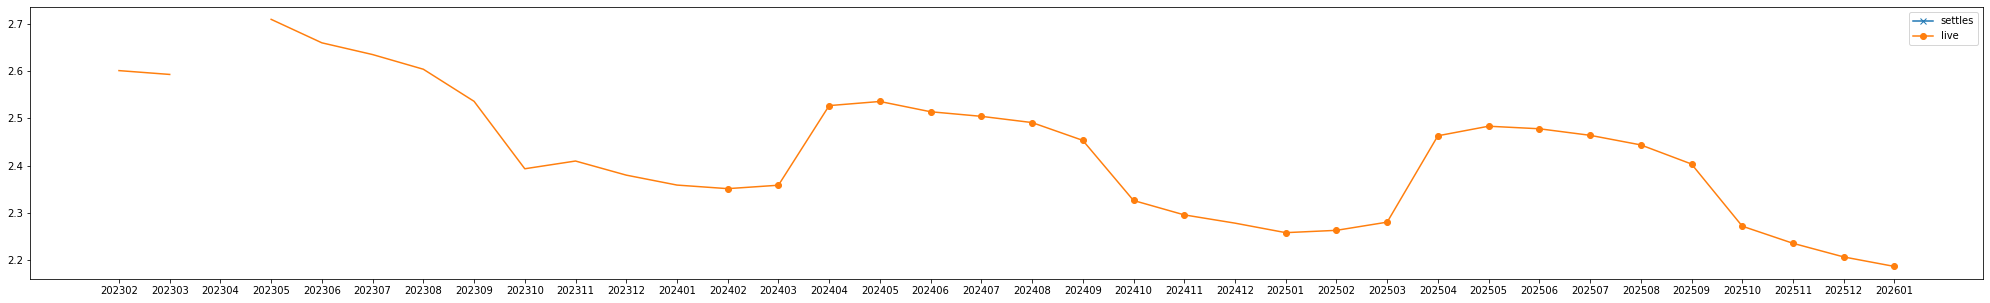

In [18]:

fig, ax = plt.subplots(figsize=(35, 5), )

df_rb['missing'] = df_rb['book_type'].apply(lambda x: x == 3)
ax.plot(df_rb['contract'], df_rb['value'], marker='x', markevery=list(df_rb['missing']) , label='settles', color='C0')
ax.plot(df_rb['contract'], df_rb['mid'], marker='o', markevery=list(df_rb['missing']) , label='live', color='C1')
ax.legend()
fig.savefig(f'c:\\temp\\RB_{today}.png')

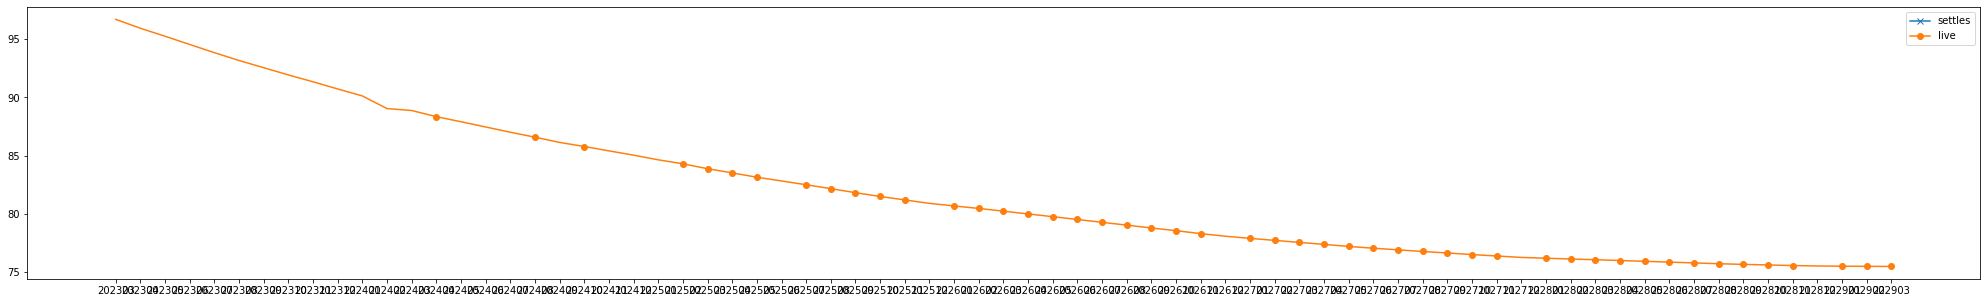

In [19]:
fig, ax = plt.subplots(figsize=(35, 5), )
df_b['missing'] = df_b['book_type'].apply(lambda x: x == 3)
ax.plot(df_b['contract'], df_b['value'], marker='x', markevery=list(df_b['missing']) , label='settles', color='C0')
ax.plot(df_b['contract'], df_b['mid'], marker='o', markevery=list(df_b['missing']) , label='live', color='C1')
ax.legend()
fig.savefig(f'c:\\temp\\B_{today}.png')

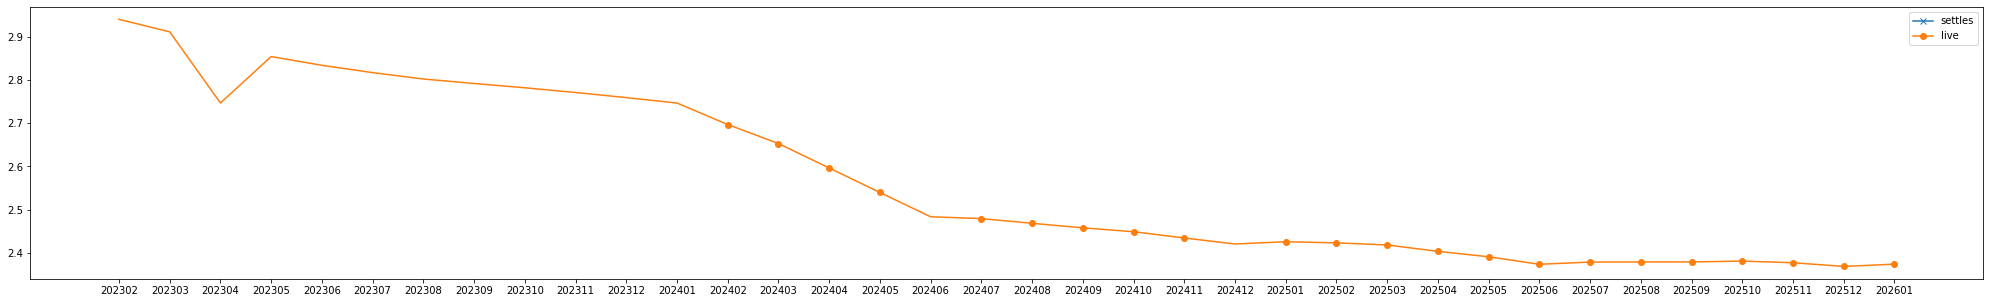

In [20]:
df_ho = df_c[df_c['symbol']=='HO'].copy()
fig, ax = plt.subplots(figsize=(35, 5), )
df_ho['missing'] = df_ho['book_type'].apply(lambda x: x == 3)
ax.plot(df_ho['contract'], df_ho['value'], marker='x', markevery=list(df_ho['missing']) , label='settles')
ax.plot(df_ho['contract'], df_ho['mid'],  marker='o', markevery=list(df_ho['missing']) , label='live', color='C1')
ax.legend()
fig.savefig(f'c:\\temp\\HO_{today}.png')

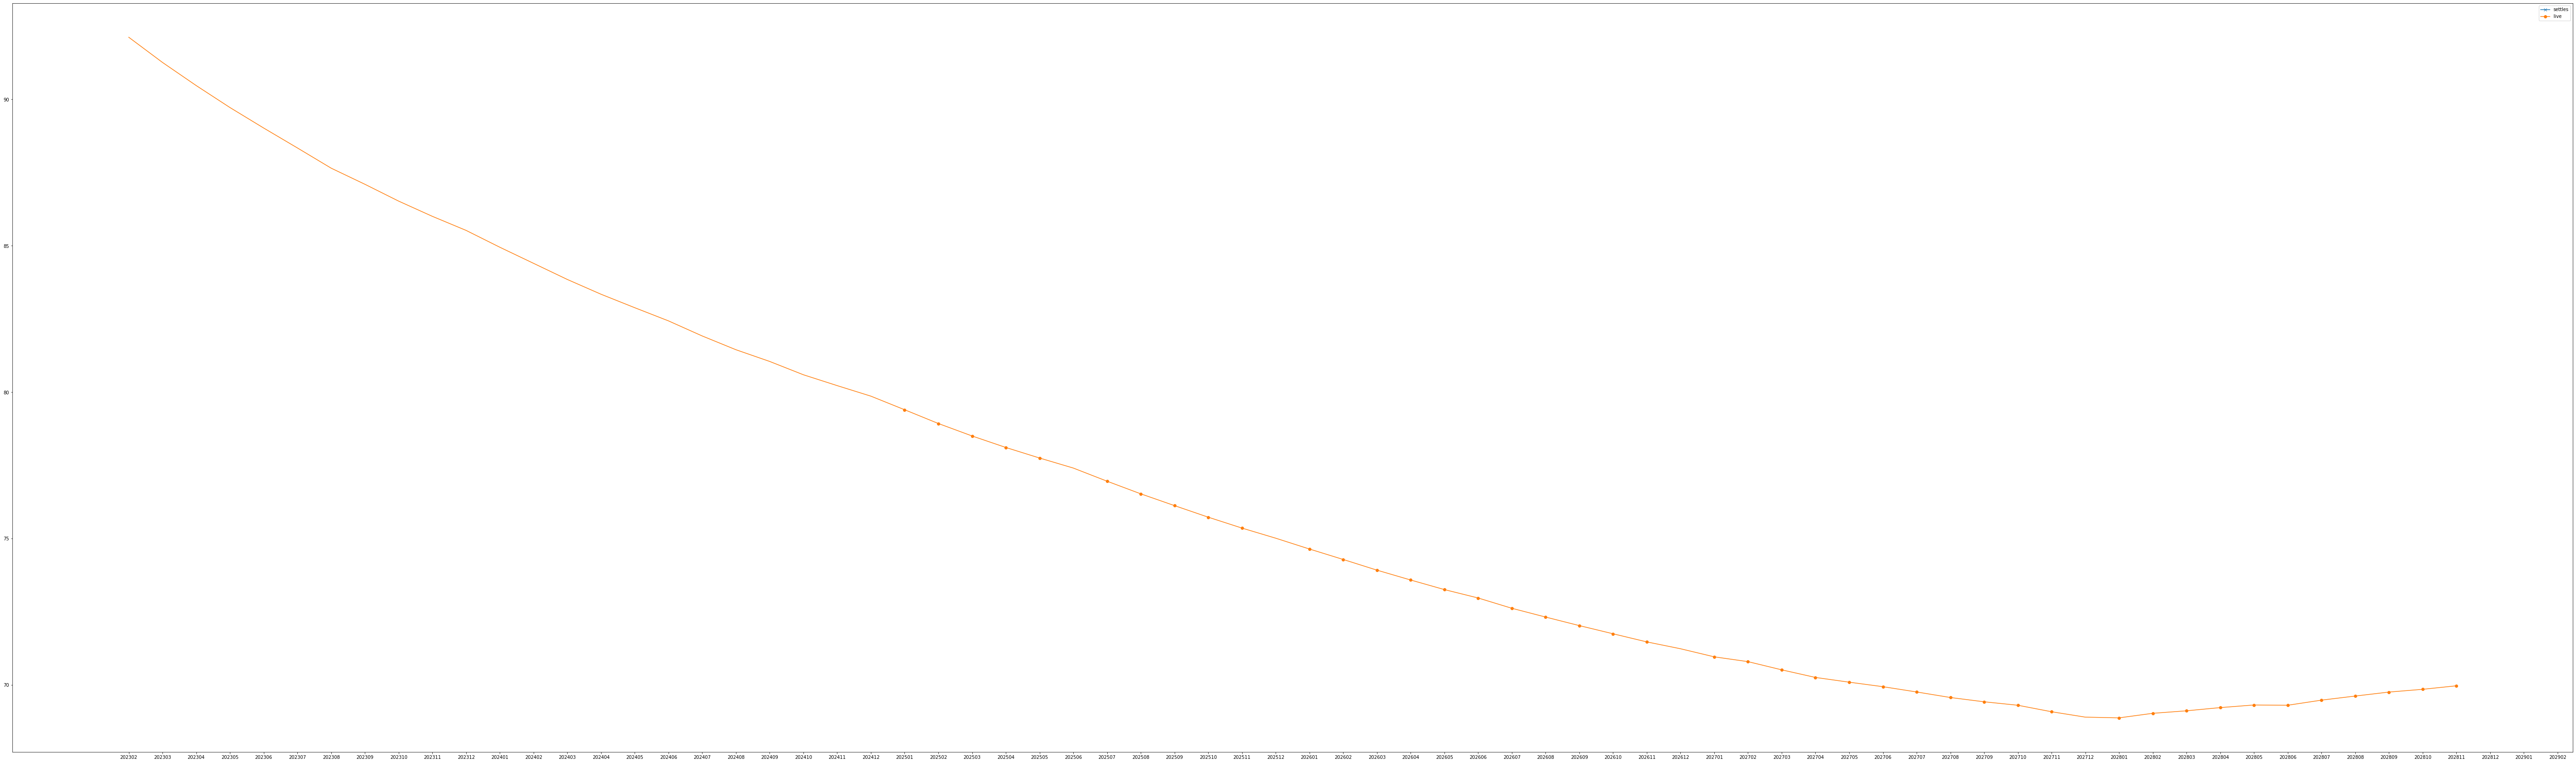

In [21]:
df_cl = df_c[df_c['symbol']=='CL'].copy()
fig, ax = plt.subplots(figsize=(100, 30), )
df_cl['missing'] = df_cl['book_type'].apply(lambda x: x == 3)
ax.plot(df_cl['contract'], df_cl['value'], marker='x', markevery=list(df_cl['missing']) , label='settles')
ax.plot(df_cl['contract'], df_cl['mid'],  marker='o', markevery=list(df_cl['missing']) , label='live', color='C1')
ax.legend()
fig.savefig(f'c:\\temp\\CL_{today}.png')